# Gesture Recognition


In [ ]:
#Importing the reuired packages.
import numpy as np
import os
from imageio import imread
from skimage.transform import resize
import datetime
import os
import matplotlib.pyplot as plt

We set the random seed so that the results don't vary drastically.

In [ ]:

np.random.seed(30)
import random as rn
rn.seed(30)
from tensorflow import keras
import tensorflow as tf
tf.random.set_seed(30)

In [ ]:
train_doc = np.random.permutation(open('/home/datasets/Project_data/train.csv').readlines()) #Reading the training doc
val_doc = np.random.permutation(open('/home/datasets/Project_data/val.csv').readlines()) #Reading the validation doc
batch_size = 8 #First experiment

In [ ]:
#Setting some fixed parameters.
img_height=120
img_width=120
num_classes=5

In [ ]:
#Function to plot the training and validation accuracy.
def plotModelHistory(h):
    fig, ax = plt.subplots(1, 2, figsize=(15,4))
    ax[0].plot(h.history['loss'])
    ax[0].plot(h.history['val_loss'])
    ax[0].legend(['loss','val_loss'])
    ax[0].title.set_text("Train loss vs Validation loss")

    ax[1].plot(h.history['categorical_accuracy'])
    ax[1].plot(h.history['val_categorical_accuracy'])
    ax[1].legend(['categorical_accuracy','val_categorical_accuracy'])
    ax[1].title.set_text("Train accuracy vs Validation accuracy")
    plt.show()

    print("Max. Training Accuracy", max(h.history['categorical_accuracy']))
    print("Max. Validaiton Accuracy", max(h.history['val_categorical_accuracy']))

## Generator


Creating the generator Class for image cropping and resizing and yielding the input to the model.

In [ ]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = range(0,29,2)#a list of image numbers you want to use
    y,z=img_height,img_width
    x=len(img_idx)
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(len(t)/batch_size)# calculate the number of batches
        for batch in range(num_batches): # iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                    #crop the images and resize them.

                    #Changing all the images into square shapes.
                    if image.shape[1] > image.shape[0]:
                        diff_px = image.shape[1] - image.shape[0]
                        crop_start = diff_px//2
                        crop_end = crop_start + image.shape[0]
                        image = image[:, crop_start:crop_end]
                    elif image.shape[0] > image.shape[1]:
                        diff_px = image.shape[0] - image.shape[1]
                        crop_start = diff_px//2
                        crop_end = crop_start + image.shape[1]
                        image = image[:, crop_start:crop_end]

                    #Resizig the images to the desired image size
                    image_resized = resize(image, (img_height, img_width),anti_aliasing=True)

                    batch_data[folder,idx,:,:,0] = (image_resized[:,:,0] - np.percentile(image_resized[:,:,0],25))/ (np.percentile(image_resized[:,:,0],75) - np.percentile(image_resized[:,:,0],25))#normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image_resized[:,:,1] - np.percentile(image_resized[:,:,1],25))/ (np.percentile(image_resized[:,:,1],75) - np.percentile(image_resized[:,:,1],25))#normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image_resized[:,:,2] - np.percentile(image_resized[:,:,2],25))/ (np.percentile(image_resized[:,:,2],75) - np.percentile(image_resized[:,:,2],25))#normalise and feed in the image

                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels # yield the batch_data and the batch_labels


        # code for the remaining data points which are left after full batches
        rem = len(t)%batch_size
        if rem != 0:
            for folder in range(rem): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*rem)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*rem)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                    #crop the images and resize them.

                    #Changing all the images into square shapes.
                    if image.shape[1] > image.shape[0]:
                        diff_px = image.shape[1] - image.shape[0]
                        crop_start = diff_px//2
                        crop_end = crop_start + image.shape[0]
                        image = image[:, crop_start:crop_end]
                    elif image.shape[0] > image.shape[1]:
                        diff_px = image.shape[0] - image.shape[1]
                        crop_start = diff_px//2
                        crop_end = crop_start + image.shape[1]
                        image = image[:, crop_start:crop_end]

                    #Resizig the images to the desired image size
                    image_resized = resize(image, (img_height, img_width),anti_aliasing=True)

                    batch_data[folder,idx,:,:,0] = (image_resized[:,:,0] - np.percentile(image_resized[:,:,0],25))/ (np.percentile(image_resized[:,:,0],75) - np.percentile(image_resized[:,:,0],25))#normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image_resized[:,:,1] - np.percentile(image_resized[:,:,1],25))/ (np.percentile(image_resized[:,:,1],75) - np.percentile(image_resized[:,:,1],25))#normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image_resized[:,:,2] - np.percentile(image_resized[:,:,2],25))/ (np.percentile(image_resized[:,:,2],75) - np.percentile(image_resized[:,:,2],25))#normalise and feed in the image

                batch_labels[folder, int(t[folder + (batch*rem)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #Yield the rest of the images.

In [ ]:
curr_dt_time = datetime.datetime.now() #Initializing to capture the date and time of the model run.
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences) #No. of training sequences.
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences) #No. of validation sequences.
num_epochs = 10# choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 10


In [ ]:
#Testing the generator for training data
sample_generator = generator(train_path, train_doc, 1)
sample_batch_data, sample_batch_labels = next(sample_generator)
print(sample_batch_data.shape)

Source path =  /home/datasets/Project_data/train ; batch size = 1
(1, 15, 120, 120, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


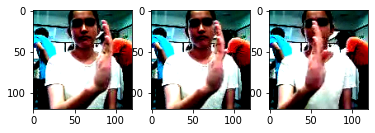

In [ ]:
# plot generated sample images
fig, ax = plt.subplots(1,3)
ax[0].imshow(sample_batch_data[0,12,:,:,:])
ax[1].imshow(sample_batch_data[0,13,:,:,:])
ax[2].imshow(sample_batch_data[0,14,:,:,:])
plt.show()

In [ ]:
#testing for validation batch
sample_val_generator = generator(val_path, val_doc, 1)
sample_val_batch_data, sample_val_batch_labels = next(sample_val_generator)
print(sample_val_batch_data.shape)


Source path =  /home/datasets/Project_data/val ; batch size = 1
(1, 15, 120, 120, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


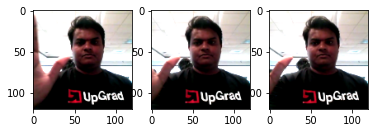

In [ ]:
# plot generated sample images
fig, ax = plt.subplots(1,3)
ax[0].imshow(sample_val_batch_data[0,12,:,:,:])
ax[1].imshow(sample_val_batch_data[0,13,:,:,:])
ax[2].imshow(sample_val_batch_data[0,14,:,:,:])
plt.show()

## Model building


In [ ]:
#Importing the required packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, LSTM, Dropout, Flatten, BatchNormalization, Activation, Conv3D, MaxPooling3D, TimeDistributed, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers
from tensorflow.keras.regularizers import l2
#write your model here

In [ ]:
input = (len(range(0,29,2)),img_height,img_width,3) #Setting the input size for the model.
np.random.seed(30)

### Base_Model

In [ ]:
#Base model
model = Sequential([
    Conv3D(16,kernel_size=3,padding='same',activation='relu',input_shape=input),
    BatchNormalization(),
    MaxPooling3D(pool_size=2),

    Conv3D(32,kernel_size=3,activation='relu',padding='same'),
    BatchNormalization(),
    MaxPooling3D(pool_size=2),

    Flatten(),
    Dense(128,kernel_regularizer=l2(0.01),activation='relu'),
    Dropout(0.2),
    Dense(num_classes,activation='softmax'),
])

2023-06-13 12:49:09.097342: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-06-13 12:49:09.097409: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14802 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1b:00.0, compute capability: 7.5


The next step is to compile the model. When you print the summary of the model, you'll see the total number of parameters you have to train.

In [ ]:
optimiser = optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 15, 120, 120, 16)  1312      
                                                                 
 batch_normalization (BatchN  (None, 15, 120, 120, 16)  64       
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 7, 60, 60, 16)    0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 7, 60, 60, 32)     13856     
                                                                 
 batch_normalization_1 (Batc  (None, 7, 60, 60, 32)    128       
 hNormalization)                                                 
                                                        

Let us create the `train_generator` and the `val_generator` which will be used in `.fit`.

In [ ]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [ ]:
model_name = '/home/dl_content/Upgrad DL/Gesture Recognition Assignment/Result/model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/' #Creating the folder name for the models to be saved.

if not os.path.exists(model_name): #Checking if folder already exists, if not then create the folder.
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5' #Path to save the model

checkpoint = ModelCheckpoint(filepath, monitor='train_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto',save_freq = 'epoch')

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit` method to decide the number of next() calls it need to make.

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [ ]:
model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 8
Epoch 1/10


2023-06-13 12:49:11.739688: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


83/83 [==============================] - ETA: 0s - loss: 286.6036 - categorical_accuracy: 0.3042Source path =  /home/datasets/Project_data/val ; batch size = 8

Epoch 00001: saving model to /home/dl_content/Upgrad DL/Gesture Recognition Assignment/Result/model_init_2023-06-1312_49_07.497684/model-00001-286.60358-0.30422-229.94092-0.19231.h5
83/83 [==============================] - 99s 1s/step - loss: 286.6036 - categorical_accuracy: 0.3042 - val_loss: 229.9409 - val_categorical_accuracy: 0.1923 - lr: 0.0100
Epoch 2/10
83/83 [==============================] - ETA: 0s - loss: 87.4059 - categorical_accuracy: 0.2455
Epoch 00002: saving model to /home/dl_content/Upgrad DL/Gesture Recognition Assignment/Result/model_init_2023-06-1312_49_07.497684/model-00002-87.40591-0.24548-37.97003-0.26923.h5
83/83 [==============================] - 98s 1s/step - loss: 87.4059 - categorical_accuracy: 0.2455 - val_loss: 37.9700 - val_categorical_accuracy: 0.2692 - lr: 0.0100
Epoch 3/10
83/83 [==============

As we didnt get good accuracy lets try experimenting with some deeper models.

### Model_1

In [ ]:
#model_1
model_1 = Sequential([
    Conv3D(16,kernel_size=3,padding='same',activation='relu',input_shape=input),
    BatchNormalization(),
    MaxPooling3D(pool_size=2),
    Dropout(0.2),

    Conv3D(32,kernel_size=3,activation='relu',padding='same'),
    BatchNormalization(),
    MaxPooling3D(pool_size=(1,2,2)),
    Dropout(0.2),

    Conv3D(64,kernel_size=3,activation='relu',padding='same'),
    BatchNormalization(),
    MaxPooling3D(pool_size=(1,2,2)),
    Dropout(0.2),

    Conv3D(128,kernel_size=3,activation='relu',padding='same'),
    BatchNormalization(),
    MaxPooling3D(pool_size=(1,2,2)),
    Dropout(0.2),

    Flatten(),
    Dense(256,kernel_regularizer=l2(0.01),activation='relu'),
    Dropout(0.2),
    Dense(num_classes,activation='softmax'),
])

In [ ]:
optimiser = optimizers.Adam(learning_rate=0.01)
model_1.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_1.summary()) #checking the model summary
#Parameters increased by a few hundred thousands.

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_2 (Conv3D)           (None, 15, 120, 120, 16)  1312      
                                                                 
 batch_normalization_2 (Batc  (None, 15, 120, 120, 16)  64       
 hNormalization)                                                 
                                                                 
 max_pooling3d_2 (MaxPooling  (None, 7, 60, 60, 16)    0         
 3D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 7, 60, 60, 16)     0         
                                                                 
 conv3d_3 (Conv3D)           (None, 7, 60, 60, 32)     13856     
                                                                 
 batch_normalization_3 (Batc  (None, 7, 60, 60, 32)   

In [ ]:
model_1.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/10
83/83 [==============================] - ETA: 0s - loss: 189.2420 - categorical_accuracy: 0.2199
Epoch 00001: saving model to /home/dl_content/Upgrad DL/Gesture Recognition Assignment/Result/model_init_2023-06-1312_49_07.497684/model-00001-189.24196-0.21988-74.22210-0.25000.h5
83/83 [==============================] - 99s 1s/step - loss: 189.2420 - categorical_accuracy: 0.2199 - val_loss: 74.2221 - val_categorical_accuracy: 0.2500 - lr: 0.0100
Epoch 2/10
83/83 [==============================] - ETA: 0s - loss: 33.2053 - categorical_accuracy: 0.2289
Epoch 00002: saving model to /home/dl_content/Upgrad DL/Gesture Recognition Assignment/Result/model_init_2023-06-1312_49_07.497684/model-00002-33.20534-0.22892-14.96543-0.33654.h5
83/83 [==============================] - 98s 1s/step - loss: 33.2053 - categorical_accuracy: 0.2289 - val_loss: 14.9654 - val_categorical_accuracy: 0.3365 - lr: 0.0100
Epoch 3/10
83/83 [==============================] - ETA: 0s - loss: 11.3351 - categoric

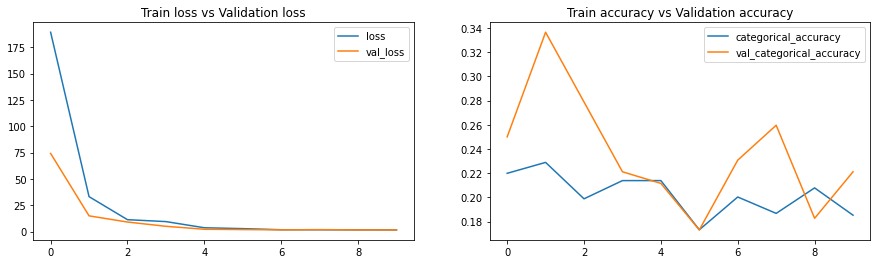

Max. Training Accuracy 0.22891566157341003
Max. Validaiton Accuracy 0.3365384638309479


In [ ]:
plotModelHistory(model_1.history)
#The validation loss improves along with the training loss.
#The validation accuracy and training accuracy are fluctuating high.

Lets try some hyperparameter tuning on this model.

In [ ]:
#Changing the batch size and nuber of epoch
batch_size=32
num_epochs=20

In [ ]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

#Running the model again with new hyperparameters.
model_1.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 32
Epoch 1/20
21/21 [==============================] - ETA: 0s - loss: 1.6399 - categorical_accuracy: 0.2173Source path =  /home/datasets/Project_data/val ; batch size = 32

Epoch 00001: saving model to /home/dl_content/Upgrad DL/Gesture Recognition Assignment/Result/model_init_2023-06-1312_49_07.497684/model-00001-1.63992-0.21726-1.65851-0.20312.h5
21/21 [==============================] - 99s 5s/step - loss: 1.6399 - categorical_accuracy: 0.2173 - val_loss: 1.6585 - val_categorical_accuracy: 0.2031 - lr: 0.0100
Epoch 2/20
21/21 [==============================] - ETA: 0s - loss: 1.6494 - categorical_accuracy: 0.2098
Epoch 00002: saving model to /home/dl_content/Upgrad DL/Gesture Recognition Assignment/Result/model_init_2023-06-1312_49_07.497684/model-00002-1.64943-0.20982-1.64350-0.26562.h5
21/21 [==============================] - 99s 5s/step - loss: 1.6494 - categorical_accuracy: 0.2098 - val_loss: 1.6435 - val_categorica

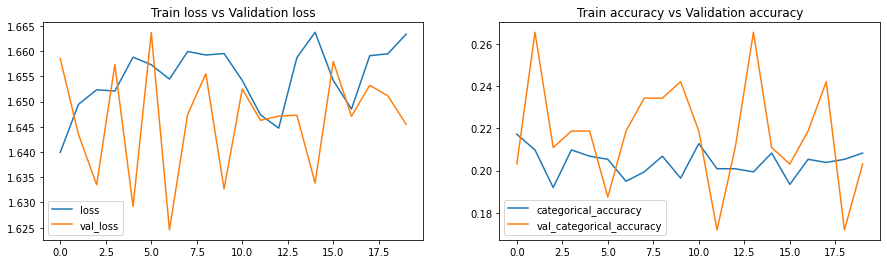

Max. Training Accuracy 0.2172619104385376
Max. Validaiton Accuracy 0.265625


In [ ]:
plotModelHistory(model_1.history)
#There is no pattern now in validation loss and training loss.
#The training accuracy stablises between 20% to 22% yet the validation accuracy is still fluctuating much.

### Model_2

In [ ]:
#model_2
#adding dropout layers in between.
model_2 = Sequential([

    Conv3D(32, kernel_size=3, activation='relu', input_shape=input),
    Conv3D(64, kernel_size=3, activation='relu'),
    MaxPooling3D(pool_size=(2, 2, 2)),
    BatchNormalization(),
    Dropout(0.2),

    Conv3D(128, kernel_size=3, activation='relu'),
    MaxPooling3D(pool_size=(1, 2, 2)),
    BatchNormalization(),
    Dropout(0.2),

    Conv3D(256, kernel_size=(1, 3, 3), activation='relu'),
    MaxPooling3D(pool_size=(1, 2, 2)),
    BatchNormalization(),
    Dropout(0.2),

    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(5, activation='softmax')
          ])

2023-06-13 16:24:43.306552: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-06-13 16:24:43.306621: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14802 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:3d:00.0, compute capability: 7.5


In [ ]:
optimiser = optimizers.Adam(learning_rate=0.01)
model_2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_2.summary()) #checking the model summary
#The learning parameters increased by millions as few more layers get added.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 13, 118, 118, 32)  2624      
                                                                 
 conv3d_1 (Conv3D)           (None, 11, 116, 116, 64)  55360     
                                                                 
 max_pooling3d (MaxPooling3D  (None, 5, 58, 58, 64)    0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 5, 58, 58, 64)    256       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 5, 58, 58, 64)     0         
                                                                 
 conv3d_2 (Conv3D)           (None, 3, 56, 56, 128)    2

In [ ]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

#Running the new model with new hyperparameters.
model_2.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 32
Epoch 1/20
21/21 [==============================] - ETA: 0s - loss: 1.9361 - categorical_accuracy: 0.4301Source path =  /home/datasets/Project_data/val ; batch size = 32

Epoch 00001: saving model to /home/dl_content/Upgrad DL/Gesture Recognition Assignment/Result/model_init_2023-06-1316_23_32.954336/model-00001-1.93611-0.43006-319.44260-0.26562.h5
21/21 [==============================] - 100s 5s/step - loss: 1.9361 - categorical_accuracy: 0.4301 - val_loss: 319.4426 - val_categorical_accuracy: 0.2656 - lr: 0.0100
Epoch 2/20
21/21 [==============================] - ETA: 0s - loss: 1.3663 - categorical_accuracy: 0.5506
Epoch 00002: saving model to /home/dl_content/Upgrad DL/Gesture Recognition Assignment/Result/model_init_2023-06-1316_23_32.954336/model-00002-1.36630-0.55060-77.66927-0.13281.h5
21/21 [==============================] - 100s 5s/step - loss: 1.3663 - categorical_accuracy: 0.5506 - val_loss: 77.6693 - val_ca

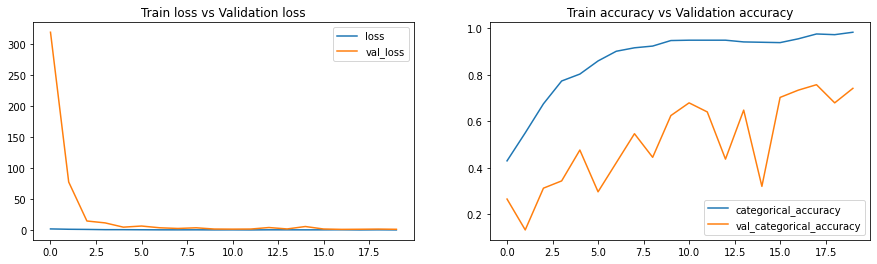

Max. Training Accuracy 0.9836309552192688
Max. Validaiton Accuracy 0.7578125


In [ ]:
plotModelHistory(model_2.history)
#The validation loss is again as the training loss.
#The validation accuracy is not fluctuating as much yet not stable.
#The accuracy is in the acceptable range now.

The model_2 has a training accuracy of 98% and validation accuracy of 76% which is acceptable yet let us try wth some other architecture to try and achieve better validation accuracy.

#Experimenting with Conv2D, Maxpooling2D and GRU.

### Model_3

In [ ]:
model_3 = Sequential([
    TimeDistributed(Conv2D(32, (3,3), activation='relu'), input_shape=input),
    TimeDistributed(MaxPooling2D((2,2))),
    BatchNormalization(),
    Dropout(0.2),

    TimeDistributed(Conv2D(64, (3,3), activation='relu')),
    TimeDistributed(MaxPooling2D((2,2))),
    BatchNormalization(),
    Dropout(0.2),

    TimeDistributed(Flatten()),
    TimeDistributed(Dense(64, activation='relu')),
    BatchNormalization(),
    Dropout(0.2),

    GRU(128),
    BatchNormalization(),
    Dense(num_classes, activation='softmax')
])

2023-06-13 18:54:20.398200: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-06-13 18:54:20.398265: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14802 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1e:00.0, compute capability: 7.5


In [ ]:
optimiser = optimizers.Adam(learning_rate=0.01)
model_3.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_3.summary()) #checking the model summary
#The no. of total parameters is reduced by millions.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 15, 118, 118, 32)  896      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 15, 59, 59, 32)   0         
 tributed)                                                       
                                                                 
 batch_normalization (BatchN  (None, 15, 59, 59, 32)   128       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 15, 59, 59, 32)    0         
                                                                 
 time_distributed_2 (TimeDis  (None, 15, 57, 57, 64)   18496     
 tributed)                                              

In [ ]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

model_3.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 32
Epoch 1/20


2023-06-13 18:54:33.853861: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


21/21 [==============================] - ETA: 0s - loss: 1.8693 - categorical_accuracy: 0.3839Source path =  /home/datasets/Project_data/val ; batch size = 32

Epoch 00001: saving model to /home/dl_content/Upgrad DL/Gesture Recognition Assignment/Result/model_init_2023-06-1318_53_28.661918/model-00001-1.86926-0.38393-1.82885-0.25000.h5
21/21 [==============================] - 101s 5s/step - loss: 1.8693 - categorical_accuracy: 0.3839 - val_loss: 1.8288 - val_categorical_accuracy: 0.2500 - lr: 0.0100
Epoch 2/20
21/21 [==============================] - ETA: 0s - loss: 1.1015 - categorical_accuracy: 0.5938
Epoch 00002: saving model to /home/dl_content/Upgrad DL/Gesture Recognition Assignment/Result/model_init_2023-06-1318_53_28.661918/model-00002-1.10145-0.59375-2.47372-0.26562.h5
21/21 [==============================] - 99s 5s/step - loss: 1.1015 - categorical_accuracy: 0.5938 - val_loss: 2.4737 - val_categorical_accuracy: 0.2656 - lr: 0.0100
Epoch 3/20
21/21 [===========================

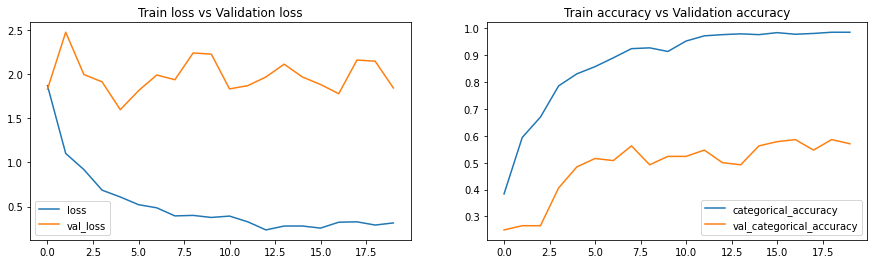

Max. Training Accuracy 0.9851190447807312
Max. Validaiton Accuracy 0.5859375


In [ ]:
plotModelHistory(model_3.history)
#In comparison to the previous model, this architecture is not able to provide much accuracy.
#The training accuracy is high whereas the validation accuracy is very low. This results the case of overfitting.
#Whe experimentde with increased parameters and running till 30 epoch, the validation accuracy has no significant improvement.

This architecture has better training accuracy but validation accuracy is not good. Lets try another architecture with LSTM.

#Creating model with Conv2D and LSTM

### Model_4

In [ ]:
model_4 = Sequential([
    TimeDistributed(Conv2D(8, (3,3), activation='relu'), input_shape=input),
    BatchNormalization(),
    TimeDistributed(Conv2D(16, (3,3), activation='relu')),

    TimeDistributed(Flatten()),
    BatchNormalization(),
    LSTM(32),
    BatchNormalization(),

    Dense(64, activation='relu'),

    BatchNormalization(),
    Dense(32, activation='relu'),
    Dense(num_classes, activation='softmax')
    ])

In [ ]:
optimiser = optimizers.Adam(learning_rate=0.01)
model_4.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_4.summary()) #checking the model summary
#This model has more parameters than the GRU model and less parameters than the Conv3D model.

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_19 (TimeDi  (None, 15, 118, 118, 8)  224       
 stributed)                                                      
                                                                 
 batch_normalization_18 (Bat  (None, 15, 118, 118, 8)  32        
 chNormalization)                                                
                                                                 
 time_distributed_20 (TimeDi  (None, 15, 116, 116, 16)  1168     
 stributed)                                                      
                                                                 
 time_distributed_21 (TimeDi  (None, 15, 215296)       0         
 stributed)                                                      
                                                                 
 batch_normalization_19 (Bat  (None, 15, 215296)      

In [ ]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

#Running the LSTM model.
model_4.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 32
Epoch 1/20
21/21 [==============================] - ETA: 0s - loss: 1.8062 - categorical_accuracy: 0.2440Source path =  /home/datasets/Project_data/val ; batch size = 32

Epoch 00001: saving model to /home/dl_content/Upgrad DL/Gesture Recognition Assignment/Result/model_init_2023-06-1318_53_28.661918/model-00001-1.80616-0.24405-1.65533-0.16406.h5
21/21 [==============================] - 103s 5s/step - loss: 1.8062 - categorical_accuracy: 0.2440 - val_loss: 1.6553 - val_categorical_accuracy: 0.1641 - lr: 0.0100
Epoch 2/20
21/21 [==============================] - ETA: 0s - loss: 1.5848 - categorical_accuracy: 0.3289
Epoch 00002: saving model to /home/dl_content/Upgrad DL/Gesture Recognition Assignment/Result/model_init_2023-06-1318_53_28.661918/model-00002-1.58482-0.32887-1.63357-0.32812.h5
21/21 [==============================] - 100s 5s/step - loss: 1.5848 - categorical_accuracy: 0.3289 - val_loss: 1.6336 - val_categori

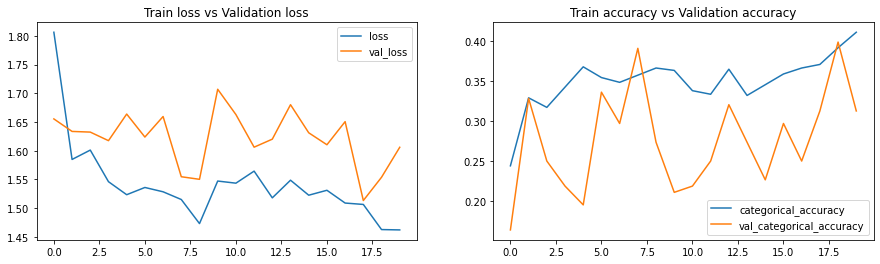

Max. Training Accuracy 0.4107142984867096
Max. Validaiton Accuracy 0.3984375


In [ ]:
plotModelHistory(model_4.history)
#We can see only the training accuracy has a gradual increase and training loss has a gradual decrease.
#The validation loss and validation accuracy are not stable.

After trying three different architectures for the same batch size, no. of frames and no. of epochs, We can clearly say that Conv3D and GRU are working much better than LSTM. We can try by updating the LSTM architecture similar to GRU architecture to get the exact idea how they all perform on same batch_size, no. of frames and no. of epochs.

### Model_5

In [ ]:
#Updating the LSTM model to make it similar to GRU and Conv3D model.
model_5 = Sequential([
    TimeDistributed(Conv2D(32, (3,3), activation='relu'), input_shape=input),
    BatchNormalization(),
    TimeDistributed(Conv2D(64, (3,3), activation='relu')),
    BatchNormalization(),
    Dropout(0.2),
    TimeDistributed(Flatten()),
    LSTM(64),
    BatchNormalization(),

    Dense(64, activation='relu'),
    Dropout(0.2),
    BatchNormalization(),
    Dense(32, activation='relu'),
    Dense(num_classes, activation='softmax')
    ])

In [ ]:
optimiser = optimizers.Adam(learning_rate=0.01)
model_5.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_5.summary()) #checking the model summary
#The number of parameters are highest in this model.

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_25 (TimeDi  (None, 15, 118, 118, 32)  896      
 stributed)                                                      
                                                                 
 batch_normalization_26 (Bat  (None, 15, 118, 118, 32)  128      
 chNormalization)                                                
                                                                 
 time_distributed_26 (TimeDi  (None, 15, 116, 116, 64)  18496    
 stributed)                                                      
                                                                 
 batch_normalization_27 (Bat  (None, 15, 116, 116, 64)  256      
 chNormalization)                                                
                                                                 
 dropout_5 (Dropout)         (None, 15, 116, 116, 64) 

In [ ]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

#Running the updated LSTM model.
model_5.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 32
Epoch 1/20


2023-06-13 20:43:22.918414: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.35GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2023-06-13 20:43:22.918471: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.35GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2023-06-13 20:43:22.954078: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.35GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2023-06-13 20:43:32.954919: W tensorflow/core/common_runtime/bfc_allocator.cc:463] Alloc

ResourceExhaustedError:  OOM when allocating tensor with shape[32,15,116,116,64] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node sequential_6/dropout_5/dropout/random_uniform/RandomUniform
 (defined at /usr/local/lib/python3.8/dist-packages/keras/layers/core/dropout.py:105)
]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_27221]

Errors may have originated from an input operation.
Input Source operations connected to node sequential_6/dropout_5/dropout/random_uniform/RandomUniform:
In[0] sequential_6/dropout_5/dropout/Shape:

Operation defined at: (most recent call last)
>>>   File "/usr/lib/python3.8/runpy.py", line 194, in _run_module_as_main
>>>     return _run_code(code, main_globals, None,
>>> 
>>>   File "/usr/lib/python3.8/runpy.py", line 87, in _run_code
>>>     exec(code, run_globals)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel_launcher.py", line 16, in <module>
>>>     app.launch_new_instance()
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/traitlets/config/application.py", line 846, in launch_instance
>>>     app.start()
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelapp.py", line 677, in start
>>>     self.io_loop.start()
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/tornado/platform/asyncio.py", line 199, in start
>>>     self.asyncio_loop.run_forever()
>>> 
>>>   File "/usr/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
>>>     self._run_once()
>>> 
>>>   File "/usr/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
>>>     handle._run()
>>> 
>>>   File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
>>>     self._context.run(self._callback, *self._args)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 461, in dispatch_queue
>>>     await self.process_one()
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 450, in process_one
>>>     await dispatch(*args)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 357, in dispatch_shell
>>>     await result
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 652, in execute_request
>>>     reply_content = await reply_content
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel/ipkernel.py", line 359, in do_execute
>>>     res = shell.run_cell(code, store_history=store_history, silent=silent)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel/zmqshell.py", line 532, in run_cell
>>>     return super().run_cell(*args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 2914, in run_cell
>>>     result = self._run_cell(
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 2960, in _run_cell
>>>     return runner(coro)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner
>>>     coro.send(None)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3185, in run_cell_async
>>>     has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3377, in run_ast_nodes
>>>     if (await self.run_code(code, result,  async_=asy)):
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3457, in run_code
>>>     exec(code_obj, self.user_global_ns, self.user_ns)
>>> 
>>>   File "/tmp/ipykernel_302/529078307.py", line 14, in <module>
>>>     model_5.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1216, in fit
>>>     tmp_logs = self.train_function(iterator)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 878, in train_function
>>>     return step_function(self, iterator)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 867, in step_function
>>>     outputs = model.distribute_strategy.run(run_step, args=(data,))
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 860, in run_step
>>>     outputs = model.train_step(data)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 808, in train_step
>>>     y_pred = self(x, training=True)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/base_layer.py", line 1083, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 92, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/sequential.py", line 373, in call
>>>     return super(Sequential, self).call(inputs, training=training, mask=mask)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py", line 451, in call
>>>     return self._run_internal_graph(
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py", line 589, in _run_internal_graph
>>>     outputs = node.layer(*args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/base_layer.py", line 1083, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 92, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/layers/core/dropout.py", line 111, in call
>>>     output = control_flow_util.smart_cond(training, dropped_inputs,
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/utils/control_flow_util.py", line 105, in smart_cond
>>>     return tf.__internal__.smart_cond.smart_cond(
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/layers/core/dropout.py", line 105, in dropped_inputs
>>>     return tf.nn.dropout(
>>> 

As the model has really high number of parameters, it returns a resource error.

As per the experiments conducted, the best model to use is the Conv3D model with a considerable amount of total parameters.

Hence the best model choice is for the **Conv3D** model (Model_2).